In [1]:
!pip install torch

In [6]:
import os
os.chdir("..")

In [7]:
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import random

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')

path = 'content/drive/MyDrive/Kings-of-Data'

Mounted at /content/drive


## **SIFT**

### **Prepare data**

In [9]:
PATH = 'content/drive/MyDrive/Kings-of-Data/data/train'
FIRST_PATH, SECOND_PATH = PATH + "/first", PATH + "/second"

first_files = sorted(os.listdir(FIRST_PATH), key=lambda x: int(x.split('.')[0]))
second_files = sorted(os.listdir(SECOND_PATH), key=lambda x: int(x.split('.')[0]))

first_files[:5], second_files[:5]

(['0_0.jpg', '1_1.jpg', '2_0.jpg', '3_1.jpg', '4_1.jpg'],
 ['0_0.jpg', '1_1.jpg', '2_0.jpg', '3_1.jpg', '4_1.jpg'])

In [10]:
FIRST_PATH + '/' + first_files[3]

'content/drive/MyDrive/Kings-of-Data/data/train/first/3_1.jpg'

### **Descriptors**

**Similar iamges**

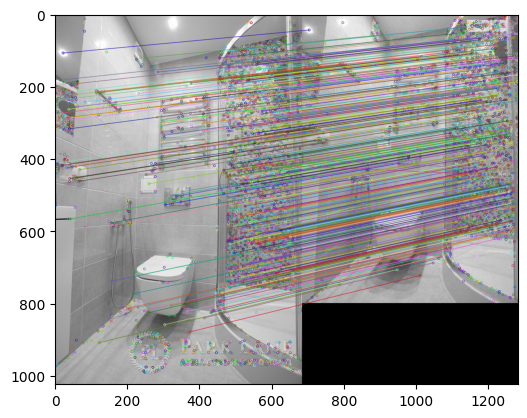

(<matplotlib.image.AxesImage at 0x7f052c3cef80>, None)

In [ ]:
img1 = cv2.imread(FIRST_PATH + "/" + first_files[3],0)
img2 = cv2.imread(SECOND_PATH + "/" + second_files[3],0)
correct_match = []
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
all_matches = bf.knnMatch(des1,des2, k=3)

for ft,sd,th in all_matches:
   if ft.distance < 0.4*sd.distance and ft.distance < 0.4*th.distance:
      correct_match.append([ft])

matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,correct_match,None,flags=0)
plt.imshow(matches)

In [ ]:
len(correct_match)

392

**Dissimilar images**

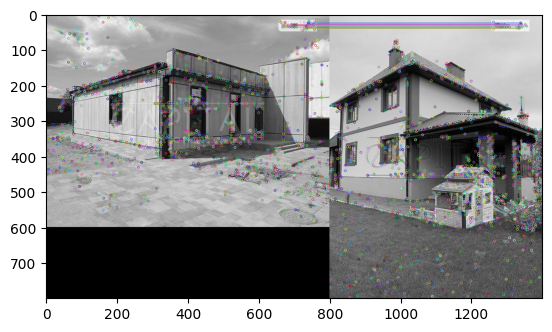

(<matplotlib.image.AxesImage at 0x7f052c42cd60>, None)

In [ ]:
img1 = cv2.imread(FIRST_PATH + "/" + first_files[1],0)
img2 = cv2.imread(SECOND_PATH + "/" + second_files[1],0)
correct_match = []
sift = cv2.SIFT_create()
bf = cv2.BFMatcher()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
all_matches = bf.knnMatch(des1,des2, k=3)

for ft,sd,th in all_matches:
   if ft.distance < 0.4*sd.distance and ft.distance < 0.4*th.distance:
      correct_match.append([ft])

matches = cv2.drawMatchesKnn(img1,kp1,img2,kp2,correct_match,None,flags=0)
plt.imshow(matches)

In [ ]:
len(correct_match)

13

## **Large sample comparison**

In [3]:
def sift_compute(img1, img2, threshold, k):
    """
    Computes the SIFT feature matching between two images.

    Args:
        img1 (numpy.ndarray): The first grayscale image.
        img2 (numpy.ndarray): The second grayscale image.
        threshold (float): The distance threshold for matching keypoints.
        k (int): The number of nearest neighbors to consider in knnMatch.
    Returns:
        numpy.ndarray: An array of good matches (keypoints) between the two images.
    """
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    try:
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=k)

    except Exception:
        return []
    
    try:
      if k == 3:
          ft, sd, th = zip(*matches)
          mask = np.array([ft[i].distance < threshold * sd[i].distance and ft[i].distance < threshold * th[i].distance for i in range(len(ft))])
          good = np.array([ft[i] for i, m in enumerate(mask) if m])
      else:
          ft, sd = zip(*matches)
          mask = np.array([ft[i].distance < threshold * sd[i].distance for i in range(len(ft))])
          good = np.array([ft[i] for i, m in enumerate(mask) if m])

    except Exception:
        return None

    return good

def compute(file_names, n=1000, k=3, threshold=0.4):
    """
    Computes the SIFT feature matching for a random sample of images.

    Args:
        file_names (list): List of image file names.
        n (int): Number of random samples to consider.
        k (int): The number of nearest neighbors to consider in knnMatch.
        threshold (float): The distance threshold for matching keypoints.
    Returns:
        tuple: Two lists containing the number of matches for dissimilar and similar images.
    """
    random_samples = random.sample(file_names, k=n)
    similar, dissimilar = [], []

    for sample in tqdm(random_samples):

      img1 = cv2.imread(FIRST_PATH + "/" + sample,0)
      img2 = cv2.imread(SECOND_PATH + "/" + sample,0)

      if img1 is None or img2 is None:
          continue

      img1 = cv2.resize(img1, (256, 256))
      img2 = cv2.resize(img2, (256, 256))

      best_matches = sift_compute(img1, img2, threshold, k)

      class_idx = sample.split('.')[0][-1]
      if int(class_idx) == 0:
          dissimilar.append(len(best_matches))
      else:
          similar.append(len(best_matches))

    return dissimilar, similar

def plot_dist_distr(zeros, ones):
    """
    Plots the distribution of distances for dissimilar and similar images.

    Args:
        zeros (list): List of distances for dissimilar images.
        ones (list): List of distances for similar images.
    """
    bin_edges = [0, 50, 100, 500, 1000, 1500, 2000, 2500, 3500, 4500, 5000, 5500, 6000]
    plt.hist(zeros, bins=bin_edges, color='blue', alpha=0.7, label='Different images')
    plt.hist(ones, bins=bin_edges, color='green', alpha=0.7, label='Same images')

    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Countplots of Distances')

    plt.legend()

    plt.show()

### **1000 samples example**

In [31]:
dissimilar,similar = compute(first_files, n=1000, threshold=0.2)

100%|██████████| 1000/1000 [10:15<00:00,  1.63it/s]


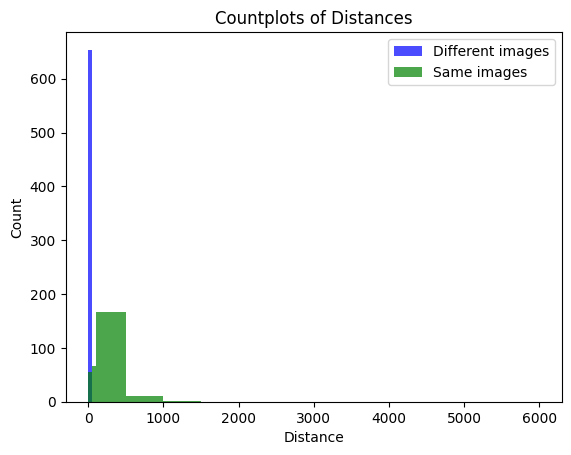

In [32]:
plot_dist_distr(dissimilar, similar)

Text(0.5, 1.0, 'Similar images')

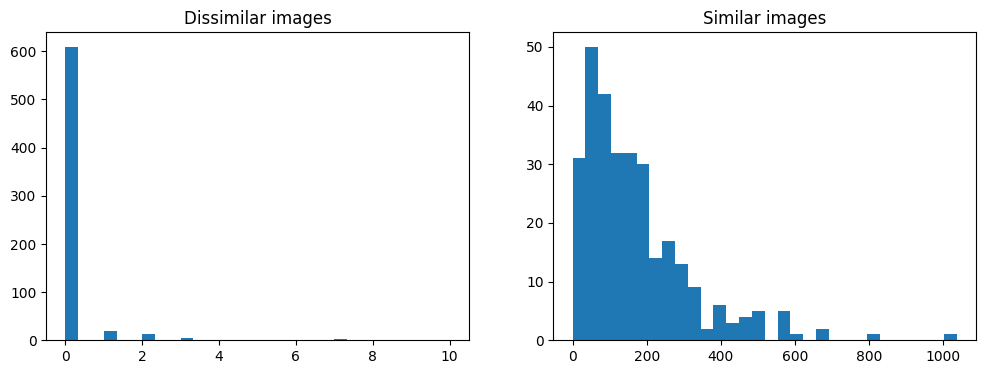

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(dissimilar, bins=30)
axs[0].set_title('Dissimilar images')

axs[1].hist(similar, bins=30)
axs[1].set_title('Similar images')

In [34]:
sorted(similar)[:15], sorted(dissimilar)[-15:]

([0, 1, 6, 6, 7, 8, 9, 12, 12, 12, 13, 15, 16, 17, 18],
 [2, 2, 2, 3, 3, 3, 3, 4, 5, 6, 7, 7, 7, 9, 10])

In [37]:
ground_truth = [0]*len(dissimilar) + [1]*len(similar)
target = dissimilar + similar

threshold = 10
result = [0 if value < threshold else 1 for value in target]

f_score = f1_score(ground_truth, result)
f_score

0.9865319865319866

### **5000 samples example**

In [38]:
dissimilar,similar = compute(first_files, n=5000, threshold=0.2)

100%|██████████| 5000/5000 [50:07<00:00,  1.66it/s]


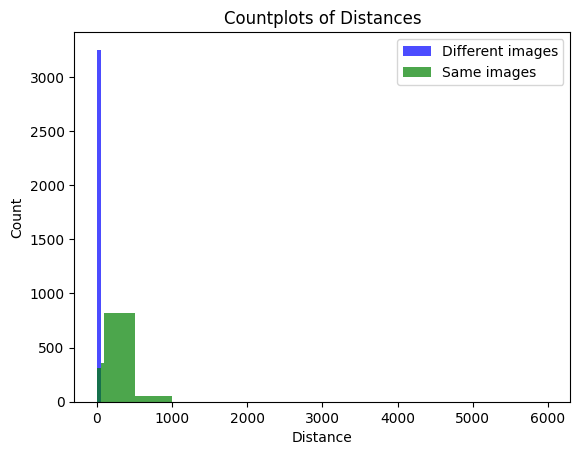

In [39]:
plot_dist_distr(dissimilar, similar)

Text(0.5, 1.0, 'Similar images')

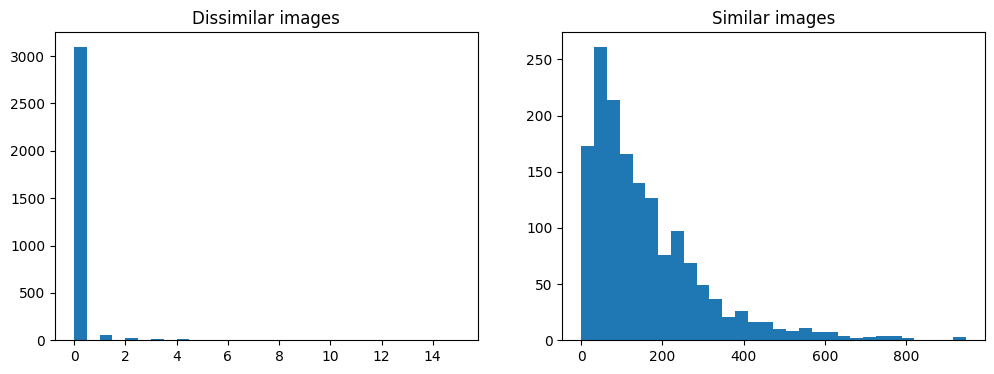

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].hist(dissimilar, bins=30)
axs[0].set_title('Dissimilar images')

axs[1].hist(similar, bins=30)
axs[1].set_title('Similar images')

In [41]:
sorted(similar)[:15], sorted(dissimilar)[-15:]

([0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 4],
 [7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 10, 10, 10, 15])

In [43]:
ground_truth = [0]*len(dissimilar) + [1]*len(similar)
target = dissimilar + similar

threshold = 10
result = [0 if value < threshold else 1 for value in target]

f_score = f1_score(ground_truth, result)
f_score

0.9840130505709626

## **Model inference**

In [8]:
PATH_TEST = 'content/drive/MyDrive/Kings-of-Data/test'
FIRST_PATH_TEST, SECOND_PATH_TEST = PATH_TEST + "/first", PATH_TEST + "/second"

first_files_test = sorted(os.listdir(FIRST_PATH_TEST), key=lambda x: int(x.split('.')[0]))
second_files_test = sorted(os.listdir(SECOND_PATH_TEST), key=lambda x: int(x.split('.')[0]))

first_files_test[:5], second_files_test[:5]

(['2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg'],
 ['2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg'])

In [9]:
len(first_files_test)

22660

In [10]:
def evaluate(file_names, k=3, dist_threshold=0.4, feat_threshold=20):
    """
    Evaluates the similarity of images based on SIFT feature matching.

    Args:
        file_names (list): List of image file names.
        k (int): The number of nearest neighbors to consider in knnMatch. Default is 3.
        dist_threshold (float): The distance threshold for matching keypoints. Default is 0.4.
        feat_threshold (int): The minimum number of matches required for considering images similar. Default is 20.
    Returns:
        tuple: A dictionary containing image IDs as keys and their similarity classes as values.
               A dictionary containing image IDs of missing images as keys and 0 as values.
    """
    data = {}
    missing = {}
    for sample in tqdm(file_names, total=len(file_names)):

      img_id = int(sample.split('.')[0])

      img1 = cv2.imread(FIRST_PATH_TEST + "/" + sample,0)
      img2 = cv2.imread(SECOND_PATH_TEST + "/" + sample,0)

      if img1 is None or img2 is None:
          missing[img_id] = 0
          continue

      img1 = cv2.resize(img1, (256, 256))
      img2 = cv2.resize(img2, (256, 256))

      best_matches = sift_compute(img1, img2, dist_threshold, k)

      if len(best_matches) < feat_threshold:
          data[img_id] = 0
      else:
          data[img_id] = 1

    return data, missing

In [16]:
data = evaluate(first_files_test, dist_threshold=0.45, feat_threshold=15)

100%|██████████| 22660/22660 [13:01<00:00, 28.99it/s] 


In [17]:
len(data[0]), len(data[1])

(20561, 2099)

In [18]:
cor_df = pd.DataFrame.from_dict(data[0], orient='index', columns=['class'])
mis_df = pd.DataFrame.from_dict(data[1], orient='index', columns=['class'])
df = pd.concat([cor_df, mis_df], axis=0)

one_hot_df = pd.get_dummies(df['class'], prefix='class')
one_hot_df.columns = ['different', 'same']

one_hot_df.insert(0, 'ID', one_hot_df.index)
one_hot_df = one_hot_df.sort_values('ID')
one_hot_df = one_hot_df[['ID', 'same', 'different']]

one_hot_df[:10]

,ID,same,different
2,2,0,1
3,3,0,1
4,4,0,1
5,5,1,0
6,6,0,1
7,7,0,1
8,8,0,1
9,9,0,1
10,10,0,1
11,11,0,1


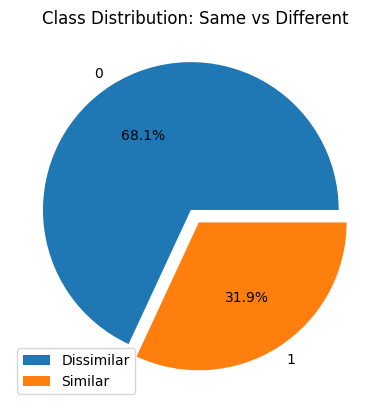

In [19]:
value_counts = cor_df['class'].value_counts()
class_labels = ['Dissimilar', 'Similar']

plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', explode=[0.05, 0.05])
plt.title('Class Distribution: Same vs Different')
plt.legend(labels=class_labels)

plt.show()

In [20]:
one_hot_df.to_csv('submission.csv', index=False)